In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
np.random.seed(42)
N = 50
NUM_GPUS = 3
rate_lam = 1 / 30  # 1 job per 30 sec
mean_duration = 40

# Generate job data
interarrival_times = np.random.exponential(scale=1 / rate_lam, size=N)
arrival_times = np.cumsum(interarrival_times)
durations = np.random.exponential(scale=mean_duration, size=N)

job_queue = pd.DataFrame({
    "job_id": range(1, N + 1),
    "arrival_time": arrival_times,
    "duration": durations,
    "gpu_required": np.random.choice([1, 2], size=N, p=[0.7, 0.3]),
    "priority": np.random.choice([0, 1, 2], size=N, p=[0.4, 0.4, 0.2]),
    "user": np.random.choice(["A", "B", "C"], size=N)
})

# Compute system utilization (ρ)
λ = 1 / np.mean(interarrival_times)
E_S = np.mean(job_queue["duration"])
E_K = np.mean(job_queue["gpu_required"])
rho = (λ * E_S * E_K) / NUM_GPUS
print(f"System utilization (ρ): {rho:.2f}")

System utilization (ρ): 0.67


The system utilization $ \rho $ is given by:

$$
\rho = \frac{\lambda \times \mathbb{E}[W]}{C} = \frac{\text{jobs per second} \times \text{GPU-seconds per job}}{\text{GPU-seconds per second available}}
$$

where:

- $ \lambda $ = arrival rate (jobs per second)  
- $ \mathbb{E}[W] $ = expected workload per job (GPU-seconds per job)  
- $ C $ = system capacity (GPU-seconds per second available)

Note: For a feasible system $ \rho $ should be less than or equal to 1 ($ \rho <= 1$).

In [ ]:
# FIFO Scheduler
def fifo_scheduler(job_queue):
    gpu_available_at = [0] * NUM_GPUS
    job_schedule = []

    for _, job in job_queue.iterrows():
        t = job["arrival_time"]
        duration = job["duration"]
        gpus_needed = job["gpu_required"]

        while t < 100000:
            available = [i for i, v in enumerate(gpu_available_at) if v <= t]
            if len(available) >= gpus_needed:
                for i in available[:gpus_needed]:
                    gpu_available_at[i] = t + duration
                job_schedule.append({
                    "job_id": job["job_id"],
                    "start_time": t,
                    "end_time": t + duration,
                    "waiting_time": t - job["arrival_time"]
                })
                break
            else:
                t += 1
    return pd.DataFrame(job_schedule)


In [ ]:
# BinPack Scheduler
def binpack_scheduler(job_queue):
    gpu_available_at = [0] * NUM_GPUS
    job_schedule = []

    for _, job in job_queue.iterrows():
        t = job["arrival_time"]
        duration = job["duration"]
        gpus_needed = job["gpu_required"]

        while t < 100000:
            available = [(i, gpu_available_at[i]) for i in range(NUM_GPUS) if gpu_available_at[i] <= t]
            if len(available) >= gpus_needed:
                sorted_avail = sorted(available, key=lambda x: x[1], reverse=True)
                for i, _ in sorted_avail[:gpus_needed]:
                    gpu_available_at[i] = t + duration
                job_schedule.append({
                    "job_id": job["job_id"],
                    "start_time": t,
                    "end_time": t + duration,
                    "waiting_time": t - job["arrival_time"]
                })
                break
            else:
                t += 1
    return pd.DataFrame(job_schedule)

In [ ]:
# Least Attending Scheduler
def least_attending_scheduler(job_queue):
    gpu_available_at = [0] * NUM_GPUS
    job_schedule = []
    user_usage = {user: 0 for user in job_queue["user"].unique()}

    for _, job in job_queue.sort_values(by="arrival_time").iterrows():
        t = job["arrival_time"]
        duration = job["duration"]
        gpus_needed = job["gpu_required"]
        user = job["user"]

        while t < 100000:
            available = [i for i, v in enumerate(gpu_available_at) if v <= t]
            if len(available) >= gpus_needed:
                if user == min(user_usage, key=user_usage.get):
                    for i in available[:gpus_needed]:
                        gpu_available_at[i] = t + duration
                    job_schedule.append({
                        "job_id": job["job_id"],
                        "user": user,
                        "start_time": t,
                        "end_time": t + duration,
                        "waiting_time": t - job["arrival_time"]
                    })
                    user_usage[user] += duration * gpus_needed
                    break
                else:
                    t += 1
            else:
                t += 1
    return pd.DataFrame(job_schedule)

In [ ]:
# Run scheduling algorithms
fifo_result = fifo_scheduler(job_queue)
binpack_result = binpack_scheduler(job_queue)
least_result = least_attending_scheduler(job_queue)


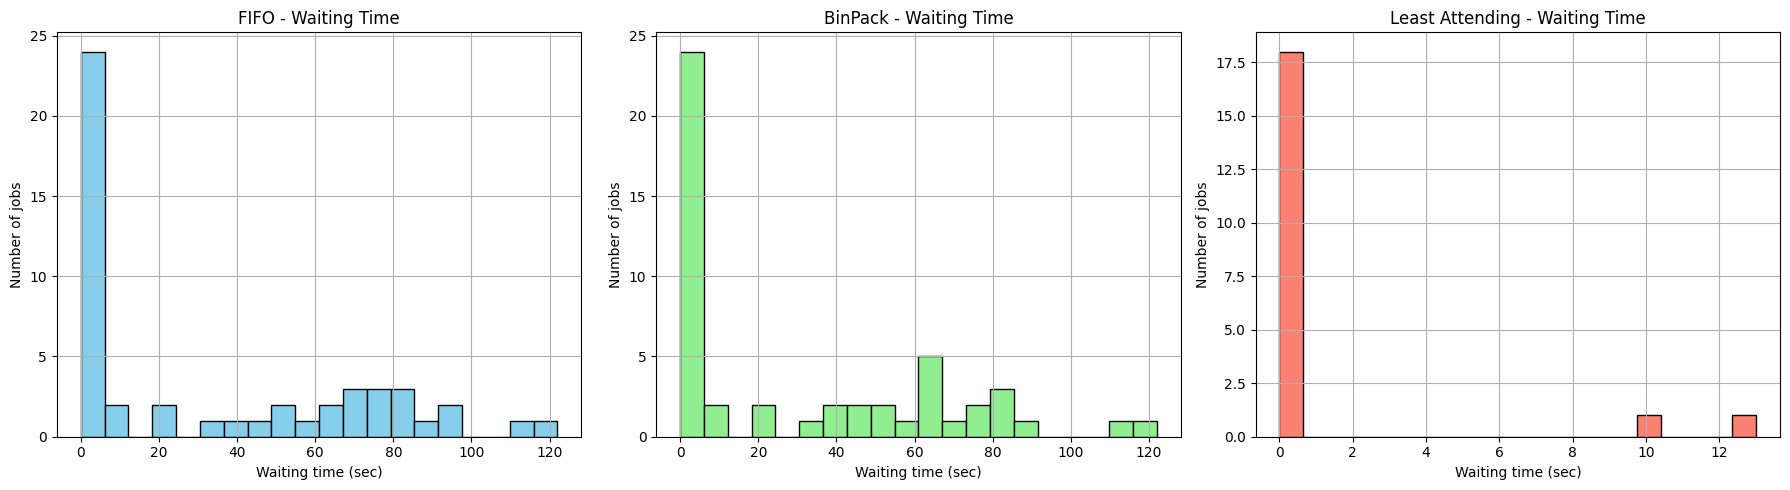

FIFO average waiting time: 33.58 seconds
BinPack average waiting time: 30.90 seconds
Least Attending average waiting time: 1.15 seconds


In [ ]:
# Plot histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
schedules = [fifo_result, binpack_result, least_result]
titles = ["FIFO", "BinPack", "Least Attending"]
colors = ["skyblue", "lightgreen", "salmon"]

for ax, sched, title, color in zip(axs, schedules, titles, colors):
    ax.hist(sched["waiting_time"], bins=20, color=color, edgecolor="black")
    ax.set_title(f"{title} - Waiting Time")
    ax.set_xlabel("Waiting time (sec)")
    ax.set_ylabel("Number of jobs")
    ax.grid(True)

plt.tight_layout()
plt.show()

# Print average waiting times
for title, sched in zip(titles, schedules):
    print(f"{title} average waiting time: {sched['waiting_time'].mean():.2f} seconds")